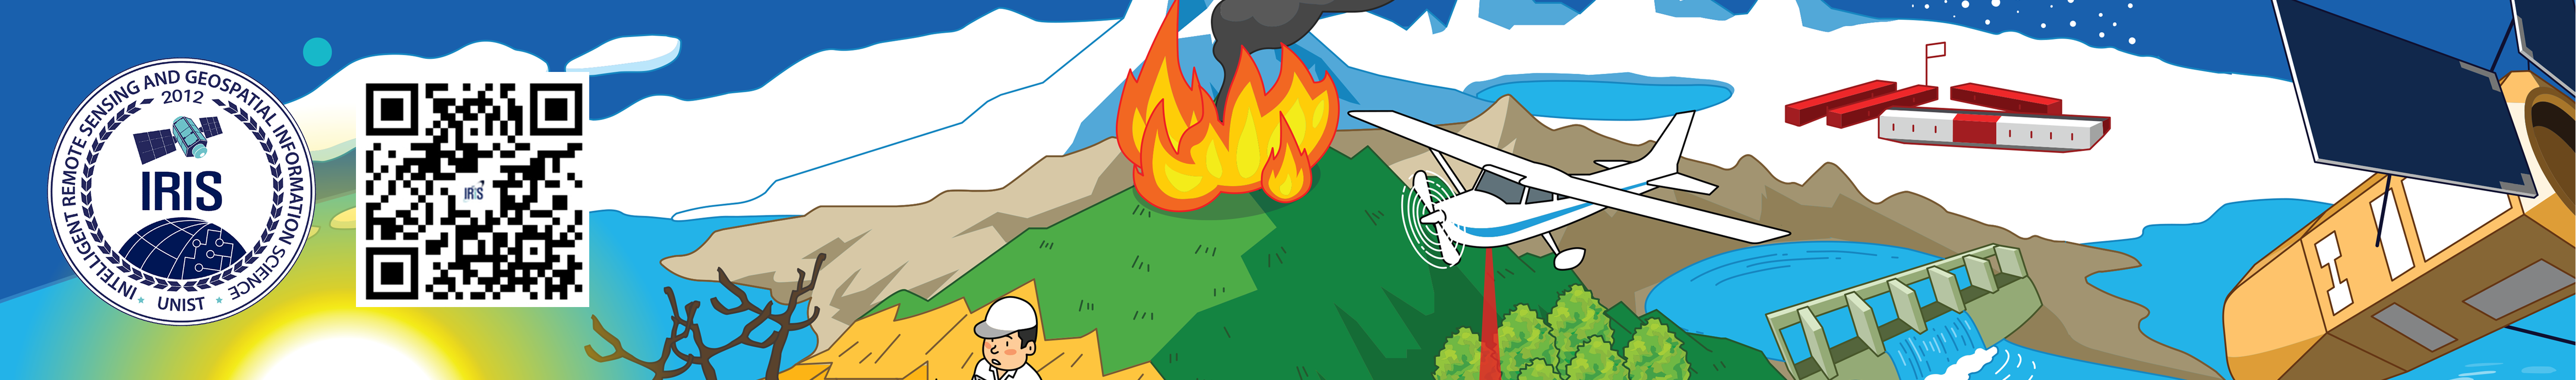


#🌲🔥 **Lab3. Reconstruction of sea surface temprature (SST) in cloud-covered regions using denoising diffusion probabilistic model (DDPM)**

> 📅 **Date** 2026.01.05 <br/>
> 👨🏻‍🏫 **Professor** Jungho Im (ersgis@unist.ac.kr)<br/>
> 👩🏻‍💻 **TA**  Minki Choo (mazera1995@unist.ac.kr), Yejin Kim (happykimmy@unist.ac.kr), So-Hyun Kim (hyun3460@unist.ac.kr)
<br/>

In this lab, you will study the basic concepts of DDPM and practice generating seamless SST data using DDPM.

<br/>

---
**Objectives are:**
- [x] Understanding of DDPM mechanism
- [x] Model inference and application to unseen SST data
---

# Overall flow

<img src='https://drive.google.com/uc?id=1Hj9DqZe4bl49nvEPiVf2Y4DTitutTs64' width="1000"/>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install einops basemap scipy cmocean

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: pyshp
    Found existing installation: pyshp 3.0.3
    Uninstalling pyshp-3.0.3:
      Successfully uninstalled pyshp-3.0.3


In [3]:
import os
root_dir = '/content/drive/MyDrive/2026_NEFU_Lab/Lab3' #change your directory
%cd /content/drive/MyDrive/2026_NEFU_Lab/Lab3/
import os
import torch
import argparse
import numpy as np
import copy
import random
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from model import CARE_SST
from diffuzz import Diffuzz, EMA
from sst_dataloader import Dataset
from util import *
import numpy as np
import matplotlib.pyplot as plt
import glob
import cmocean

/content/drive/MyDrive/2026_NEFU_Lab/Lab3


In [4]:
# Set random seeds
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Argument parsing
parser = argparse.ArgumentParser(description="SST reconstruction", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--mode", default="mask_reconstruction", choices=["train", "mask_reconstruction", "cloud_reconstruction", "test_time_series"], type=str)
parser.add_argument("--train_continue", default="off", choices=["on", "off"], type=str)
parser.add_argument("--lr", default=1e-4, type=float)
parser.add_argument("--batch_size", default=4, type=int)
parser.add_argument("--num_epoch", default=10, type=int)
parser.add_argument("--data_dir", default=root_dir+'/data', type=str)
parser.add_argument("--network", default="CARE_SST", choices=["CARE_SST"], type=str)
args = parser.parse_args([])

In [6]:
# Directory setup
model_dir = os.path.join(root_dir, 'result')
sub_dirs = ['checkpoint', f'{args.mode}/png', f'{args.mode}/numpy']
setup_directories(model_dir, sub_dirs)
ckpt_dir = os.path.join(model_dir, 'checkpoint')
result_dir = os.path.join(model_dir, args.mode)

In [7]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG = CARE_SST().to(device)
# Optimizer and other necessary components
optG = torch.optim.AdamW(netG.parameters(), lr=args.lr)
diffuzz = Diffuzz(device=device)
ema = EMA(0.995)
ema_model = copy.deepcopy(netG).eval().requires_grad_(False)
mse = nn.MSELoss()
_float16_dtype = torch.bfloat16

In [8]:
# DataLoader setup
def get_dataloader(data_dir, mode, batch_size):
    transform = transforms.Compose([])

    import os
    if mode == 'test_time_series':
        sub_dir = 'time_series'
    elif mode == 'cloud_reconstruction':
        sub_dir = 'cloud'
    else:
        sub_dir = 'clear_sky'

    viirs_dir = os.path.join(data_dir, sub_dir, 'viirs')
    oisst_dir = os.path.join(data_dir, sub_dir, 'oisst')

    dataset = Dataset(viirs_dir=viirs_dir, oisst_dir=oisst_dir, transform=transform, mask_type=mode)
    return DataLoader(dataset, batch_size=batch_size, drop_last=(mode == 'train'), shuffle=(mode == 'train'), num_workers=16, pin_memory=True), len(dataset)

if args.mode == 'train':
    loader_train, _ = get_dataloader(args.data_dir, args.mode, args.batch_size)
else:
    loader_test, num_data_test = get_dataloader(args.data_dir, args.mode, args.batch_size)
    num_batch_test = np.ceil(num_data_test / args.batch_size)

st_epoch = 0

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def train_or_reconstruct(
    args, netG, optG, ema, ema_model, diffuzz, mse, loader,
    ckpt_dir, result_dir, _float16_dtype=torch.bfloat16
):
    """
    Mode summary
    - args.mode == 'train'            : diffusion noise prediction training
    - args.mode == 'test_time_series' : inference with past context + comparison without context
    - else                            : normal reconstruction inference (structure only)
    """
    device = next(netG.parameters()).device

    # =========================================================================
    # Mode 1: Training
    # =========================================================================
    if args.mode == 'train':
        st_epoch = 0

        # Optionally resume training from checkpoint
        if args.train_continue == "on":
            netG, optG, st_epoch = load(ckpt_dir=ckpt_dir, netG=netG, optG=optG)

        for epoch in range(st_epoch + 1, args.num_epoch + 1):
            loss_arr = []

            for batch, images in enumerate(loader, 1):
                # Load batch data
                structure_image = images['structure_image'].to(device)
                gt_image = images['gt_image'].to(device)

                # -------------------------------------------------------------
                # 1) Prepare noisy inputs (diffusion forward process)
                # -------------------------------------------------------------
                optG.zero_grad()

                with torch.no_grad():
                    # Sample continuous time t in [0.001, 1.0] (slightly extended then clamped)
                    t = (
                        torch.rand(gt_image.size(0), device=device)
                        .mul(1.08)
                        .add(0.001)
                        .clamp(0.001, 1.0)
                    )

                    # Diffuse ground truth image to get noisy image and true noise
                    noised_images, noise = diffuzz.diffuse(gt_image, t)

                # -------------------------------------------------------------
                # 2) Predict noise and compute loss
                # -------------------------------------------------------------
                with torch.cuda.amp.autocast(dtype=_float16_dtype):
                    # Input to netG: concatenation of noised image and structure/background
                    pred_noise = netG(torch.cat((noised_images, structure_image), dim=1), t)
                    loss = mse(pred_noise, noise).mean()

                # -------------------------------------------------------------
                # 3) Backprop + optimizer step + EMA update
                # -------------------------------------------------------------
                loss.backward()
                optG.step()

                # Update EMA model parameters
                ema.step_ema(ema_model, netG)

                # Logging
                loss_arr.append(loss.item())
                print(
                    f"TRAIN: EPOCH {epoch:04d} / {args.num_epoch:04d} | "
                    f"BATCH {batch:04d} | LOSS {np.mean(loss_arr):.4f}"
                )

            # Save checkpoint periodically
            if epoch % 10 == 0:
                save(ckpt_dir=ckpt_dir, netG=netG, optG=optG, ema_model=ema_model, epoch=epoch)

    # =========================================================================
    # Mode 2 & 3: Inference (Time Series & Reconstruction)
    # =========================================================================
    else:
        # Load trained checkpoint
        netG, optG, st_epoch = load(ckpt_dir=ckpt_dir, netG=netG, optG=optG)

        # Visualization timesteps (negative indexing from the sampled trajectory)
        vis_timesteps = [-200, -150, -100, -50, -25, -1]

        with torch.no_grad():
            netG.eval()

            for batch, images in enumerate(loader, 1):
                # -----------------------------------------------------------
                # Common batch data
                # -----------------------------------------------------------
                structure_image = images['structure_image'].to(device)
                gt_image = images['gt_image'].to(device)
                mask = images['inpaint_map'].to(device)

                # Safety initialization for context-related variables
                context = None

                # Main / secondary predictions
                pred_with_context = None   # main output (uses past context if available)
                pred_no_context = None     # comparison output (structure only, only in time-series mode)

                # This will hold the list of intermediate samples to visualize
                vis_target_steps = None
                vis_suffix = ""

                # -----------------------------------------------------------
                # A. Time Series Mode (with past context)
                # -----------------------------------------------------------
                if args.mode == 'test_time_series':
                    context = images['context'].to(device)

                    # 1) With Context (Main Output)
                    sampled_ts = diffuzz.sample_blending_denoise_background_one_day(
                        model=netG,
                        background=structure_image,
                        context_past=context[:, 0][:, None],
                        past_mask=context[:, 1][:, None],
                        shape=gt_image.shape,
                        mask=mask,
                        x_init=gt_image,
                        sampler='ddpm',
                        timesteps=200
                    )

                    # Pick visualization snapshots at specified indices
                    sampled_ts_steps = [sampled_ts[s] for s in vis_timesteps]
                    pred_with_context = sampled_ts_steps[-1]

                    # 2) Without Context (Comparison Output)
                    sampled_struct = diffuzz.sample(
                        model=netG,
                        background=structure_image,
                        shape=gt_image.shape,
                        mask=mask,
                        x_init=gt_image,
                        sampler='ddpm',
                        timesteps=200
                    )
                    pred_no_context = sampled_struct[-1]

                    # Visualization is based on the "with context" trajectory
                    vis_target_steps = sampled_ts_steps
                    vis_suffix = "_context"

                # -----------------------------------------------------------
                # B. Normal Reconstruction Mode (structure only)
                # -----------------------------------------------------------
                else:
                    sampled_all = diffuzz.sample(
                        model=netG,
                        background=structure_image,
                        shape=gt_image.shape,
                        mask=mask,
                        x_init=gt_image,
                        sampler='ddpm',
                        timesteps=200
                    )

                    vis_target_steps = [sampled_all[s] for s in vis_timesteps]
                    pred_with_context = vis_target_steps[-1]  # main output in normal mode
                    vis_suffix = ""

                # -----------------------------------------------------------
                # Saving & Visualization Loop (per-sample in the batch)
                # -----------------------------------------------------------
                for j in range(gt_image.shape[0]):
                    id = args.batch_size * (batch - 1) + j

                    # Meta information needed for post-processing / masking
                    meta = {
                        'min': images['oisst_min'][j].squeeze().cpu().numpy(),
                        'max': images['oisst_max'][j].squeeze().cpu().numpy(),
                        'land_mask': images['land_mask'][j].squeeze().cpu().numpy(),
                        'cloud_mask': images['gt_cloud_mask'][j].squeeze().cpu().numpy(),
                        'inpaint_mask': mask[j].squeeze().cpu().numpy()
                    }

                    # 1) Save visualization image (intermediate sampled steps)
                    save_path = os.path.join(
                        result_dir, 'png', f'{id:04d}_sampled_images_steps{vis_suffix}.png'
                    )

                    save_visualization(
                        sampled_steps=[s[j] for s in vis_target_steps],
                        timesteps=vis_timesteps,
                        meta_data=meta,
                        save_path=save_path
                    )

                    # 2) Post-process images to real value range and apply masks
                    gt_img_proc = post_process(
                        gt_image[j],
                        meta['min'], meta['max'],
                        meta['land_mask'], meta['cloud_mask']
                    )

                    # Input image: replace inpaint region with NaN for visualization/evaluation
                    input_img_proc = np.where(meta['inpaint_mask'] == 1, np.nan, gt_img_proc)

                    # Structure/background image (typically one channel at [j, 0])
                    struct_img_proc = post_process(
                        structure_image[j, 0],
                        meta['min'], meta['max'],
                        meta['land_mask']
                    )

                    # Main output: context-reflected output if available (or normal reconstruction output)
                    out_main_proc = post_process(
                        pred_with_context[j],
                        meta['min'], meta['max'],
                        meta['land_mask']
                    )

                    imgs = {
                        'output_img': out_main_proc,   # Main Output (With Context in time-series mode)
                        'gt_img': gt_img_proc,
                        'oisst_img': struct_img_proc,
                        'input_img': input_img_proc
                    }

                    # Time-series mode: save additional comparison outputs
                    if args.mode == 'test_time_series':
                        out_struct_proc = post_process(
                            pred_no_context[j],
                            meta['min'], meta['max'],
                            meta['land_mask']
                        )

                        past_img_proc = post_process(
                            context[j, 0],
                            meta['min'], meta['max'],
                            meta['land_mask']
                        )

                        # Renamed key only (variable names are unchanged): explicitly indicate no-context output
                        imgs['output_no_ctx_img'] = out_struct_proc
                        imgs['past_img'] = past_img_proc

                    # Save outputs (images + arrays)
                    save_images_and_arrays(id, imgs, meta['min'], meta['max'], result_dir)


# Masked region reconstruction

<img src='https://drive.google.com/uc?id=1BtdAwtwvJaYAUgvpLxybom0Ok3ZzM2pv' width="1000"/>

In [11]:
args.mode = "mask_reconstruction"

train_or_reconstruct(args, netG, optG, ema, ema_model, diffuzz, mse, loader_test, ckpt_dir, result_dir)

Sampling Progress: 100%|██████████| 200/200 [03:04<00:00,  1.09it/s]
/content/drive/MyDrive/2026_NEFU_Lab/Lab3/util.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


<Figure size 640x480 with 0 Axes>

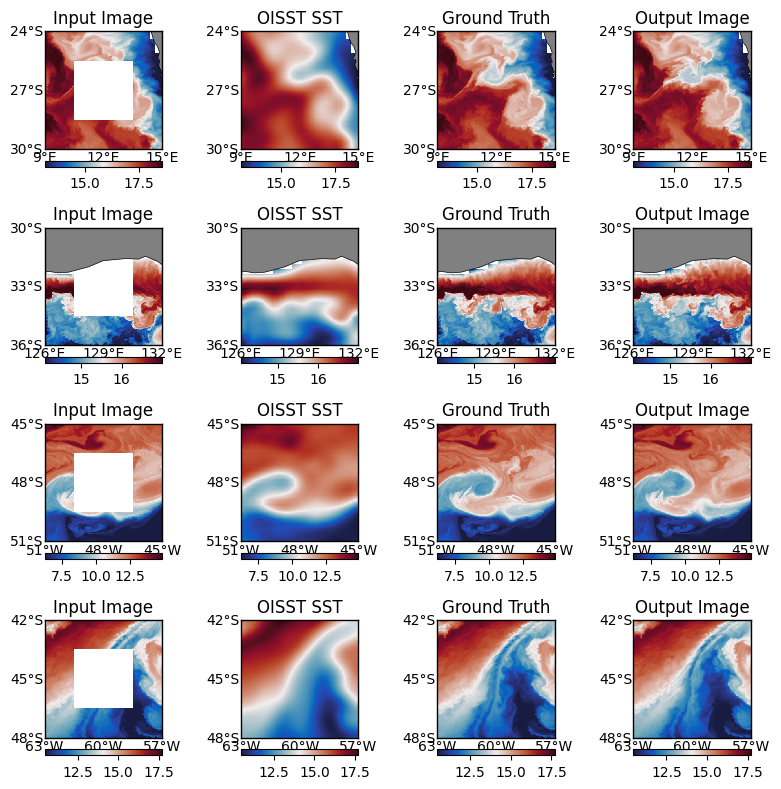

In [19]:
gt_file_lst =  sorted(glob.glob(root_dir+'/result/mask_reconstruction/numpy/*_gt_img.npy'))
input_file_lst =  sorted(glob.glob(root_dir+'/result/mask_reconstruction/numpy/*_input_img.npy'))
output_file_lst =  sorted(glob.glob(root_dir+'/result/mask_reconstruction/numpy/*_output_img.npy'))
oisst_file_lst =  sorted(glob.glob(root_dir+'/result/mask_reconstruction/numpy/*_oisst_img.npy'))
lonlat_lst =  sorted(glob.glob(root_dir+'/data/clear_sky/lon_lat/viirs/*.npy'))

# Create 4x4 subplot
fig, axes = plt.subplots(4, 4, figsize=(8, 8), dpi=100)
axes = axes.flatten()

# Loop through the indices 0 to 3 and plot the images
for n in range(4):
    output = np.load(output_file_lst[n])
    input_img = np.load(input_file_lst[n])
    gt_img = np.load(gt_file_lst[n])
    oisst_sst = np.load(oisst_file_lst[n])
    lonlat_grid = np.load(lonlat_lst[n])

    a = lonlat_grid[:,:,0].squeeze()
    b = lonlat_grid[:,:,1].squeeze()
    bbox = [round(a.min()), round(b.min()), round(a.max()), round(b.max())]

    # Plot the images in the subplot
    draw_map(axes[n*4 + 0], input_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Input Image')
    draw_map(axes[n*4 + 1], oisst_sst.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='OISST SST')
    draw_map(axes[n*4 + 2], gt_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Ground Truth')
    draw_map(axes[n*4 + 3], output.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Output Image')

plt.tight_layout()
plt.show()

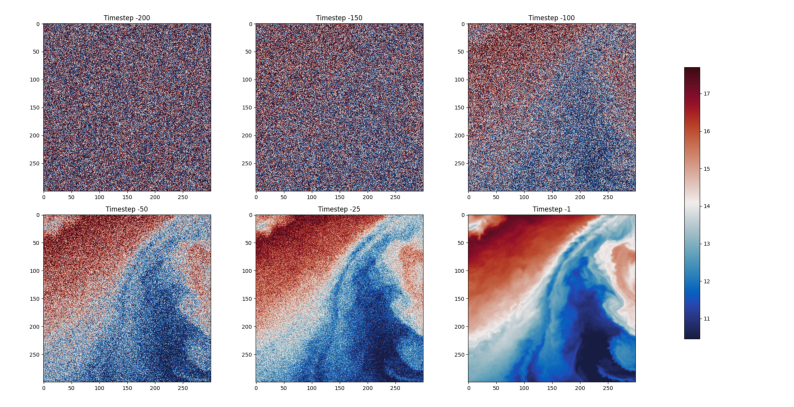

In [13]:
from PIL import Image

# PNG path
denoise_step_file_lst = glob.glob(root_dir+'/result/mask_reconstruction/png/*_sampled_images_steps.png')

# Load image
image = Image.open(denoise_step_file_lst[3])

# Image visualization
plt.subplots(figsize=(10, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

# Scheme 1 vs Scheme 3

<img src='https://drive.google.com/uc?id=1H06mUD6swkKoT6b6SZYtp8V5pxG2-VM7' width="1000"/>

In [14]:
args.mode = "test_time_series"
# Directory setup
model_dir = os.path.join(root_dir, 'result')
sub_dirs = ['checkpoint', f'{args.mode}/png', f'{args.mode}/numpy']
setup_directories(model_dir, sub_dirs)
ckpt_dir = os.path.join(model_dir, 'checkpoint')
result_dir = os.path.join(model_dir, args.mode)

loader_test, num_data_test = get_dataloader(args.data_dir, args.mode, args.batch_size)

train_or_reconstruct(args, netG, optG, ema, ema_model, diffuzz, mse, loader_test, ckpt_dir, result_dir)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Sampling Progress: 100%|██████████| 200/200 [01:36<00:00,  2.07it/s]
/content/drive/MyDrive/2026_NEFU_Lab/Lab3/util.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


<Figure size 640x480 with 0 Axes>

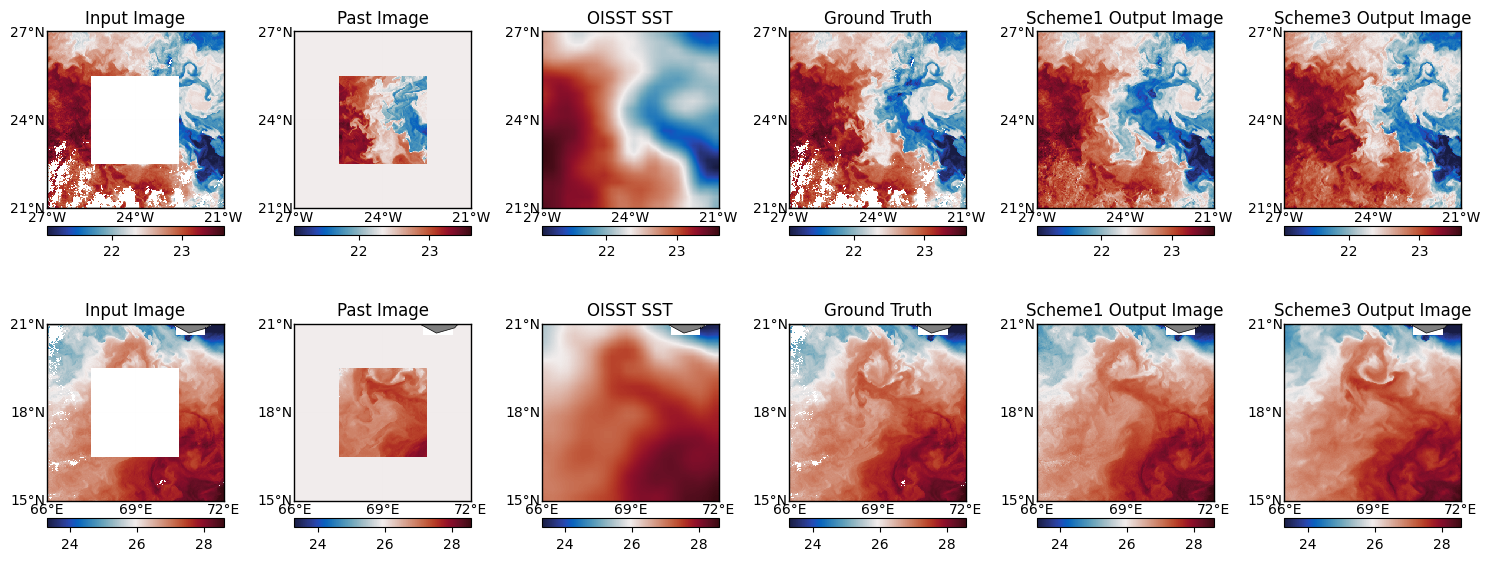

In [15]:
gt_file_lst =  sorted(glob.glob(root_dir+'/result/test_time_series/numpy/*_gt_img.npy'))
past_file_lst =  sorted(glob.glob(root_dir+'/result/test_time_series/numpy/*_past_img.npy'))
input_file_lst =  sorted(glob.glob(root_dir+'/result/test_time_series/numpy/*_input_img.npy'))
output_scheme1_file_lst =  sorted(glob.glob(root_dir+'/result/test_time_series/numpy/*_output_no_ctx_img.npy'))
output_scheme3_file_lst =  sorted(glob.glob(root_dir+'/result/test_time_series/numpy/*_output_img.npy'))
oisst_file_lst =  sorted(glob.glob(root_dir+'/result/test_time_series/numpy/*_oisst_img.npy'))
lonlat_lst =  sorted(glob.glob(root_dir+'/data/time_series/lon_lat/viirs/*.npy'))

# Create 4x4 subplot
fig, axes = plt.subplots(2, 6, figsize=(15, 6), dpi=100)
axes = axes.flatten()

# Loop through the indices 0 to 3 and plot the images
for n in range(2):
    output = np.load(output_scheme1_file_lst[n])
    output_ctx = np.load(output_scheme3_file_lst[n])
    input_img = np.load(input_file_lst[n])
    gt_img = np.load(gt_file_lst[n])
    oisst_sst = np.load(oisst_file_lst[n])
    lonlat_grid = np.load(lonlat_lst[n])
    past_img = np.load(past_file_lst[n])

    a = lonlat_grid[:,:,0].squeeze()
    b = lonlat_grid[:,:,1].squeeze()
    bbox = [round(a.min()), round(b.min()), round(a.max()), round(b.max())]

    # Plot the images in the subplot
    draw_map(axes[n*6 + 0], input_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Input Image')
    draw_map(axes[n*6 + 1], past_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Past Image')
    draw_map(axes[n*6 + 2], oisst_sst.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='OISST SST')
    draw_map(axes[n*6 + 3], gt_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Ground Truth')
    draw_map(axes[n*6 + 4], output.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Scheme1 Output Image')
    draw_map(axes[n*6 + 5], output_ctx.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Scheme3 Output Image')

plt.tight_layout()
plt.show()

# Cloud area reconstruction using Scheme 1




<img src='https://drive.google.com/uc?id=1rDTsUqi8ld2g6Xk7RquOyJlRTbv6n4u3' width="800"/>

In [16]:
args.mode = "cloud_reconstruction"
# Directory setup
model_dir = os.path.join(root_dir, 'result')
sub_dirs = ['checkpoint', f'{args.mode}/png', f'{args.mode}/numpy']
setup_directories(model_dir, sub_dirs)
ckpt_dir = os.path.join(model_dir, 'checkpoint')
result_dir = os.path.join(model_dir, args.mode)

loader_test, num_data_test = get_dataloader(args.data_dir, args.mode, args.batch_size)

train_or_reconstruct(args, netG, optG, ema, ema_model, diffuzz, mse, loader_test, ckpt_dir, result_dir)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Sampling Progress: 100%|██████████| 200/200 [03:05<00:00,  1.08it/s]
/content/drive/MyDrive/2026_NEFU_Lab/Lab3/util.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])
Sampling Progress: 100%|██████████| 200/200 [00:52<00:00,  3.79it/s]


<Figure size 640x480 with 0 Axes>

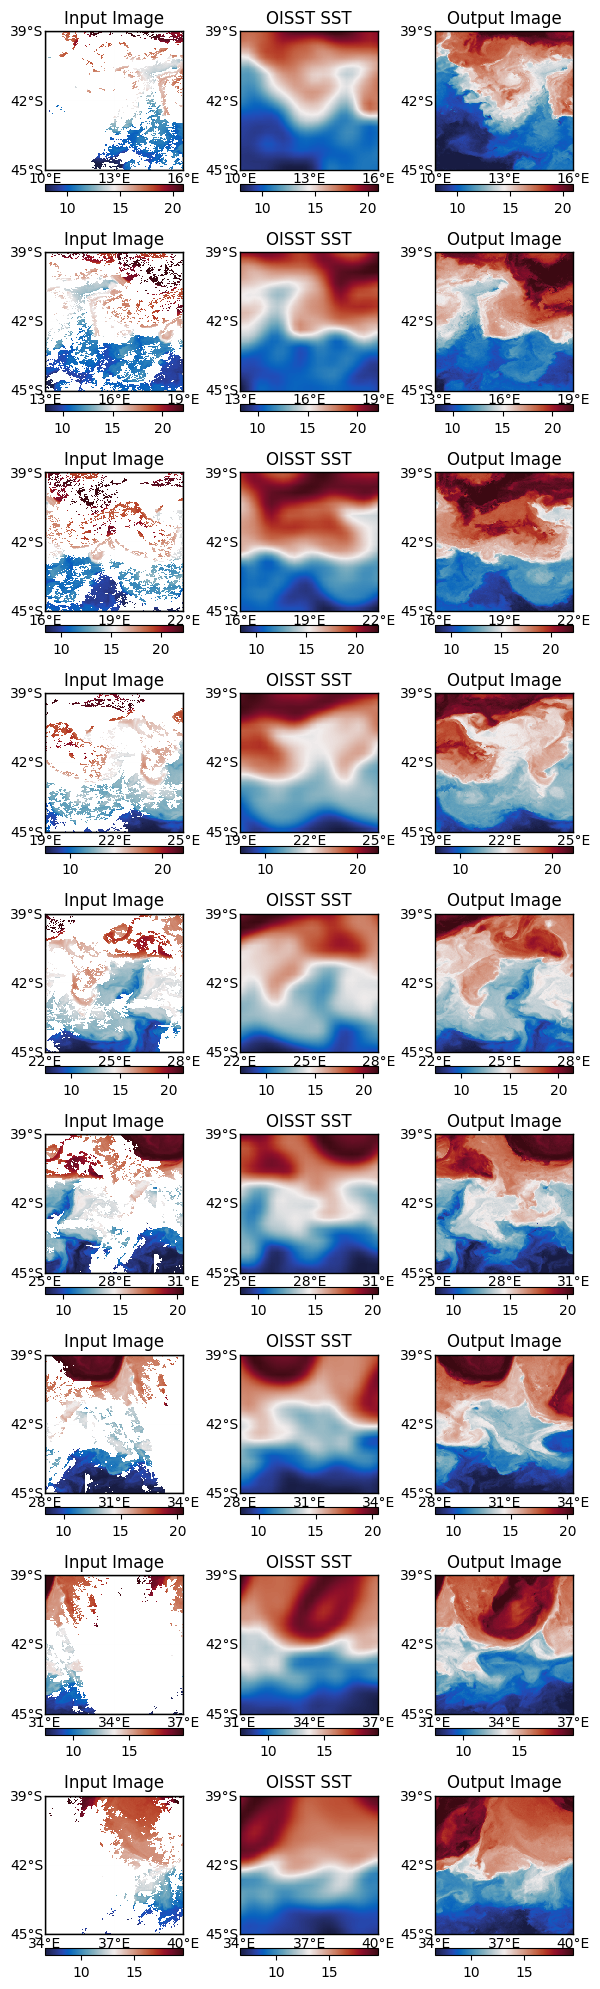

In [17]:
gt_file_lst =  sorted(glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_gt_img.npy'))
input_file_lst =  sorted(glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_input_img.npy'))
output_file_lst =  sorted(glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_output_img.npy'))
oisst_file_lst =  sorted(glob.glob(root_dir+'/result/cloud_reconstruction/numpy/*_oisst_img.npy'))
lonlat_lst =  sorted(glob.glob(root_dir+'/data/cloud/lon_lat/viirs/*.npy'))

fig, axes = plt.subplots(9, 3, figsize=(6, 20), dpi=100)
axes = axes.flatten()

for n in range(9):
    output = np.load(output_file_lst[n])
    input_img = np.load(input_file_lst[n])
    gt_img = np.load(gt_file_lst[n])
    oisst_sst = np.load(oisst_file_lst[n])
    lonlat_grid = np.load(lonlat_lst[n])

    a = lonlat_grid[:,:,0].squeeze()
    b = lonlat_grid[:,:,1].squeeze()
    bbox = [round(a.min()), round(b.min()), round(a.max()), round(b.max())]

    # Plot the images in the subplot
    draw_map(axes[n*3 + 0], input_img.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Input Image')
    draw_map(axes[n*3 + 1], oisst_sst.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='OISST SST')
    draw_map(axes[n*3 + 2], output.squeeze(), a, b, bbox, np.nanmin(oisst_sst), np.nanmax(oisst_sst), title='Output Image')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3578892523.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


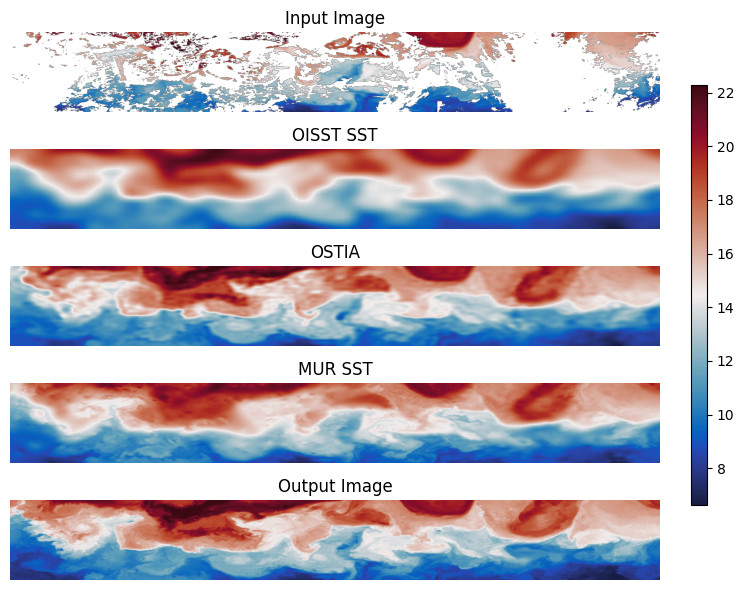

In [18]:
mursst = np.load(root_dir+'/data/cloud/mursst/20220101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.npy')[-600:,:,0]
ostia = np.load(root_dir+'/data/cloud/ostia/20220101120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.npy')[-120:,:,0]

# Concatenate images from file lists
def concatenate_images(file_lst):
    concatenated_image = []
    for file in file_lst:
        img = np.load(file)
        concatenated_image.append(img.squeeze())
    return np.concatenate(concatenated_image, axis=1)

input_img_concat = concatenate_images(input_file_lst[::2])
oisst_sst_concat = concatenate_images(oisst_file_lst[::2])

grid_size = (1, 9)
overlap = 150
output_blend = load_and_blend_images(output_file_lst, grid_size, overlap)


# List of all images to display
images = [input_img_concat, oisst_sst_concat, ostia, mursst, output_blend]
titles = ['Input Image', 'OISST SST', 'OSTIA', 'MUR SST', 'Output Image']

# Determine the min and max values for color scaling based on oisst_sst_concat
vmin = oisst_sst_concat.min()
vmax = oisst_sst_concat.max()

# Plot the images in a single figure
fig, axes = plt.subplots(len(images), 1, figsize=(8, 6), dpi=100)

for ax, img, title in zip(axes, images, titles):
    im = ax.imshow(img, vmin=vmin, vmax=vmax, aspect='auto',cmap=cmocean.cm.balance)
    ax.set_title(title)
    ax.axis('off')

# Add a single colorbar for all images
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()



source: https://github.com/mkchoo/CARE-SST